In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


REAL = "Real"
FAKE = "Fake"

targets = {REAL: 0, FAKE: 1}

true_df = pd.read_csv("../datasets/True.csv")
fake_df = pd.read_csv("../datasets/Fake.csv")

print(true_df.shape)
print(fake_df.shape)

(21417, 4)
(23481, 4)


In [43]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [44]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Gathering the data

In [45]:
true_df["target"] = REAL
fake_df["target"] = FAKE

df = pd.concat([true_df, fake_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
print(df.shape)
df.head(10)

(44898, 5)


,title,text,subject,date,target
0,"Trumpcare Is Officially Dead, Senator Collins...","Graham-Cassidy, the latest and worst in a line...",News,"September 26, 2017",Fake
1,Bolstered Libyan coast guard intercepts packed...,TRIPOLI (Reuters) - Libya s European-backed co...,worldnews,"November 4, 2017",Real
2,WATCH: Megyn Kelly Takes A Shot At Hannity By...,Fox News host Megyn Kelly seemed to take a sho...,News,"September 27, 2016",Fake
3,WOW! Do Anti-Trump Protesters REALLY Know What...,Wow! Talk about clueless! Austen Fletcher appr...,politics,"Jul 17, 2017",Fake
4,Now Trump Wants to ‘Drain The Sewer’ So The I...,"Donald Trump is losing it. On Monday, he kicke...",News,"July 24, 2017",Fake
5,U.S. military joins Brazil army exercises in A...,"TABATINGA, Brazil (Reuters) - U.S. military pe...",worldnews,"November 8, 2017",Real
6,Hawaii Attorney General HUMILIATES Jeff Sessi...,Donald Trump s Attorney General just got schoo...,News,"April 21, 2017",Fake
7,"Trump doubles monthly campaign fundraising, la...",NEW YORK/WASHINGTON (Reuters) - Republican pre...,politicsNews,"June 21, 2016",Real
8,Hurricane Irma threatens luxury Trump properties,(Reuters) - Hurricane Irma swept over U.S. Pre...,worldnews,"September 6, 2017",Real
9,Anti-Trump Protester Surrounded By Mexican Fla...,It was actually refreshing to see the cops fig...,left-news,"May 28, 2016",Fake


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


# Cleaning text

In [47]:
import re


def clean_text(text: str) -> str:
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s!?]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.lower().strip()


df["text"] = df["text"].apply(clean_text)
df["title"] = df["title"].apply(clean_text)
df.head()

,title,text,subject,date,target
0,trumpcare is officially dead senator collins c...,graham cassidy the latest and worst in a line ...,News,"September 26, 2017",Fake
1,bolstered libyan coast guard intercepts packed...,tripoli reuters libya s european backed coast ...,worldnews,"November 4, 2017",Real
2,watch megyn kelly takes a shot at hannity by w...,fox news host megyn kelly seemed to take a sho...,News,"September 27, 2016",Fake
3,wow! do anti trump protesters really know what...,wow! talk about clueless! austen fletcher appr...,politics,"Jul 17, 2017",Fake
4,now trump wants to drain the sewer so the inte...,donald trump is losing it on monday he kicked ...,News,"July 24, 2017",Fake


# Amount of fake news and real news

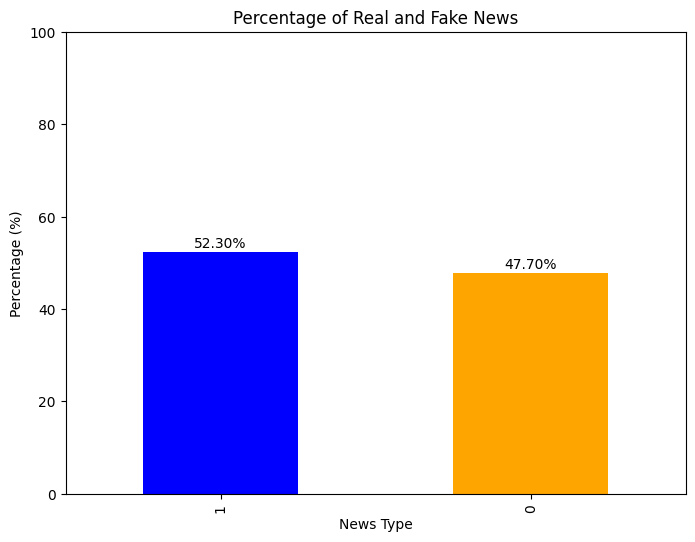

In [73]:
target_percentage_map = df["target"].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
target_percentage_map.plot(kind="bar", color=['blue', 'orange'])
plt.title("Percentage of Real and Fake News")
plt.xlabel("News Type")
plt.ylabel("Percentage (%)")
for index, value in enumerate(target_percentage_map):
    plt.text(index, value + 1, f"{value:.2f}%", ha='center')

plt.ylim(0, 100)
filename = "dataset.png"
plt.savefig(filename, dpi=300)
plt.show()

# Preparing data

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


vectorizer = TfidfVectorizer(max_features=100, stop_words='english')

df["combined_text"] = df["title"] + " " + df["text"]
df["target"] = df["target"].map(targets)

X_train, X_test, y_train, y_test = train_test_split(
    df["combined_text"],
    df["target"],
    test_size=0.2,
    random_state=42,
    stratify=df["target"]
)

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

y_train = y_train.to_numpy()
y_test  = y_test.to_numpy()

print("Training feature matrix shape:", X_train.shape)
print("Testing feature matrix shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training feature matrix shape: (35918, 100)
Testing feature matrix shape: (8980, 100)
Training labels shape: (35918,)
Testing labels shape: (8980,)


# Grid Search

Performing Grid Search for MLPClassifier...
Best parameters for MLPClassifier: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01, 'max_iter': 120}
Saved PNG file: gridsearch_MLPClassifier.png


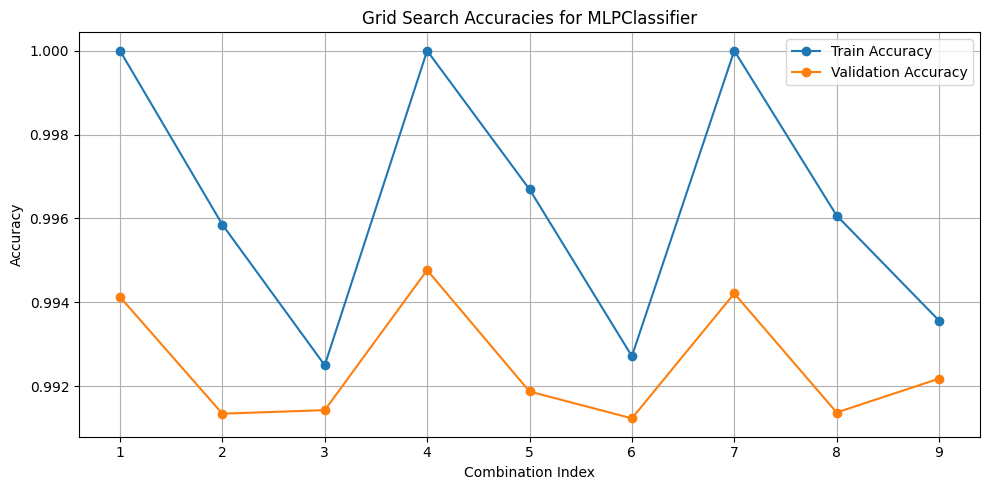

Performing Grid Search for RandomForestClassifier...
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
Saved PNG file: gridsearch_RandomForestClassifier.png


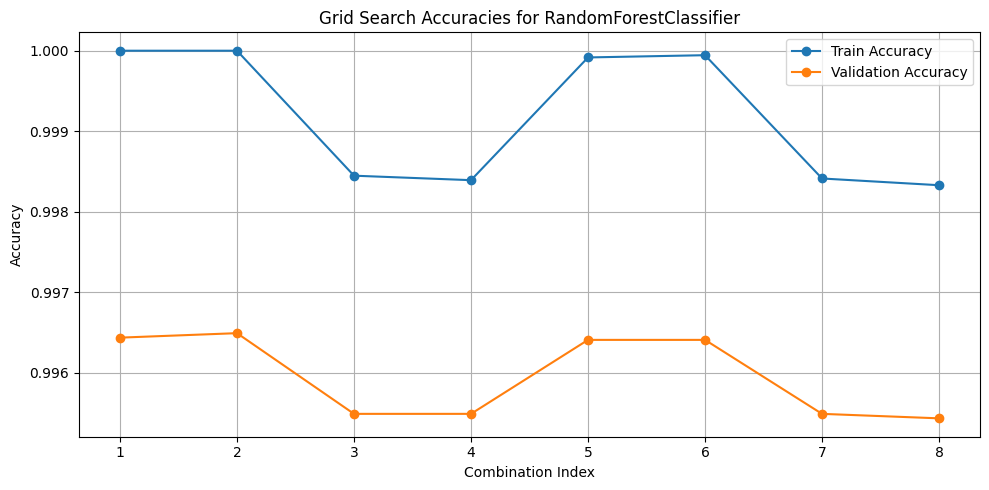

Performing Grid Search for MultinomialNB...
Best parameters for MultinomialNB: {'alpha': 0.1}
Saved PNG file: gridsearch_MultinomialNB.png


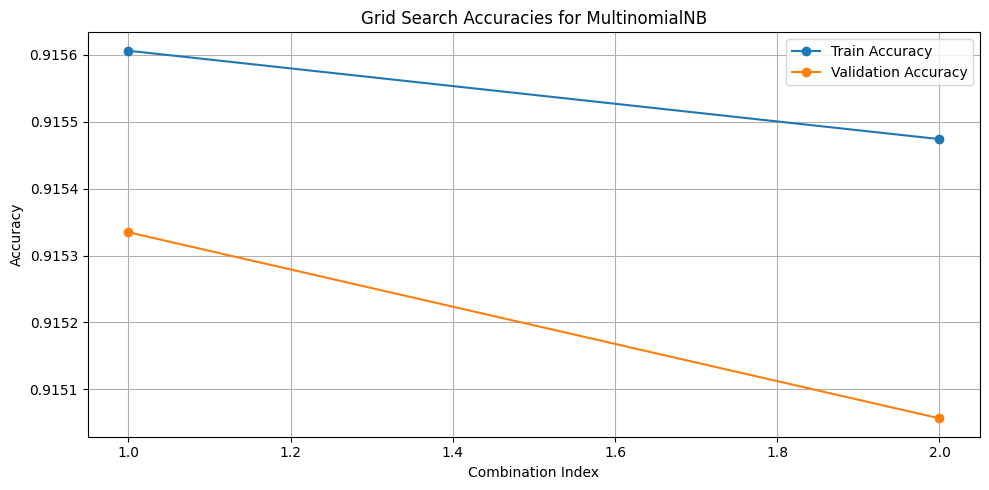

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

MLP           = "MLPClassifier"
RANDOM_FOREST = "RandomForestClassifier"
NAIVE_BAYES   = "MultinomialNB"


def plot_results(results: dict, model_name: str):
    train_scores = results["mean_train_score"]
    test_scores = results["mean_test_score"]

    train_indices = range(1, len(train_scores) + 1)
    test_indices  = range(1, len(test_scores) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(train_indices, train_scores, label='Train Accuracy', marker='o')
    plt.plot(test_indices, test_scores, label='Validation Accuracy', marker='o')
    plt.title(f'Grid Search Accuracies for {model_name}')
    plt.xlabel('Combination Index')
    plt.ylabel('Accuracy')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    filename = f"gridsearch_{model_name}.png"
    plt.savefig(filename, dpi=300)
    print(f"Saved PNG file: {filename}")
    plt.show()


models = {
    MLP: MLPClassifier(random_state=42),
    RANDOM_FOREST: RandomForestClassifier(random_state=42),
    NAIVE_BAYES: MultinomialNB()
}

param_grids = {
    MLP: {
        "hidden_layer_sizes": [
            (50, 25),
            (100, 50),
            (150, 75)
        ],
        "learning_rate_init": [0.01, 0.1, 0.25],
        "activation": ["relu"],
        "alpha": [0.0001],
        "max_iter": [120]
    },
    RANDOM_FOREST: {
        "n_estimators": [100, 200],
        "max_depth": [None, 20],
        "min_samples_leaf": [1, 2]
    },
    NAIVE_BAYES: {
        "alpha": [0.1, 1.0]
    }
}

best_models = {}

for model_name, model in models.items():
    print(f"Performing Grid Search for {model_name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        return_train_score=True
    )
    grid.fit(X_train, y_train)
    best_models[model_name] = grid.best_estimator_
    print(f"Best parameters for {model_name}: {grid.best_params_}")

    results = grid.cv_results_
    plot_results(results, model_name)

# Traning Model

Accuracy for MLPClassifier: 0.9954
Classification Report for MLPClassifier:
               precision    recall  f1-score   support

        Real     0.9956    0.9949    0.9952      4284
        Fake     0.9953    0.9960    0.9956      4696

    accuracy                         0.9954      8980
   macro avg     0.9954    0.9954    0.9954      8980
weighted avg     0.9954    0.9954    0.9954      8980



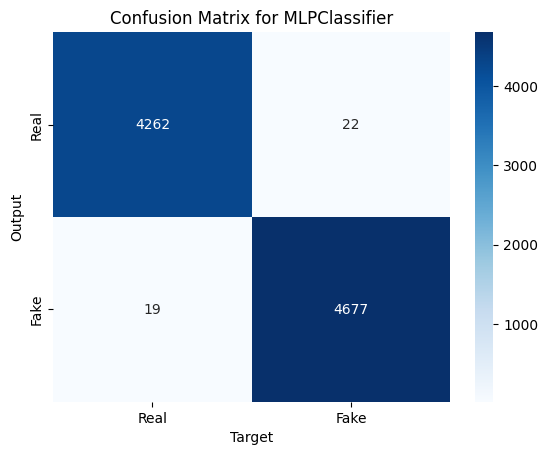

Accuracy for RandomForestClassifier: 0.9970
Classification Report for RandomForestClassifier:
               precision    recall  f1-score   support

        Real     0.9960    0.9977    0.9969      4284
        Fake     0.9979    0.9964    0.9971      4696

    accuracy                         0.9970      8980
   macro avg     0.9970    0.9970    0.9970      8980
weighted avg     0.9970    0.9970    0.9970      8980



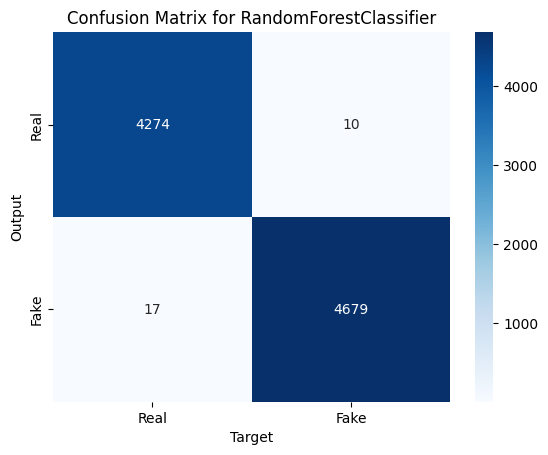

Accuracy for MultinomialNB: 0.9161
Classification Report for MultinomialNB:
               precision    recall  f1-score   support

        Real     0.8942    0.9349    0.9141      4284
        Fake     0.9380    0.8991    0.9181      4696

    accuracy                         0.9161      8980
   macro avg     0.9161    0.9170    0.9161      8980
weighted avg     0.9171    0.9161    0.9162      8980



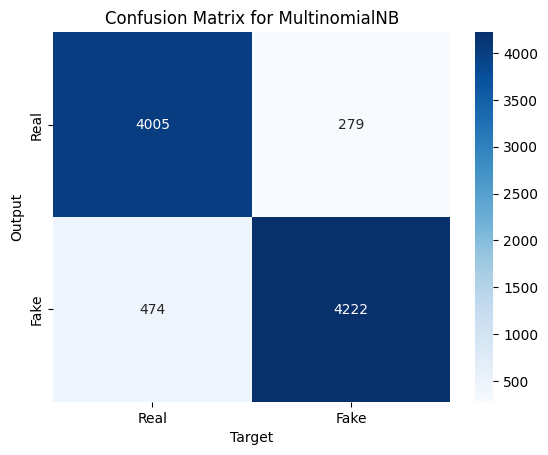

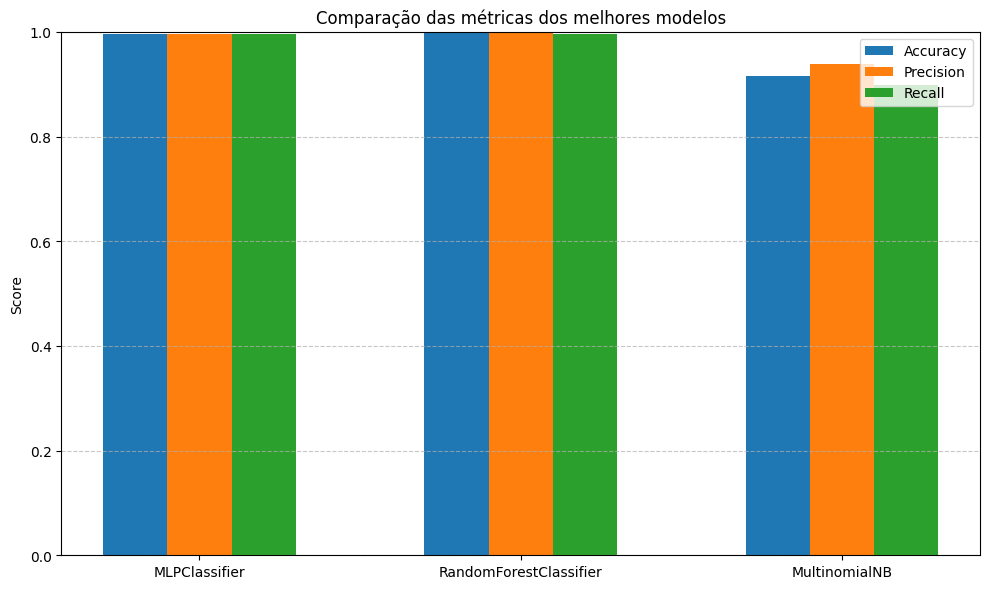

In [72]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np


def plot_metrics_comparison(best_models: dict):
    global accuracies, precisions, recalls
    model_names = list(best_models.keys())

    accuracy_vals = [accuracies[m] for m in model_names]
    precision_vals = [precisions[m] for m in model_names]
    recall_vals = [recalls[m] for m in model_names]

    x = np.arange(len(model_names))
    width = 0.2

    plt.figure(figsize=(10,6))
    plt.bar(x - width, accuracy_vals, width, label='Accuracy')
    plt.bar(x, precision_vals, width, label='Precision')
    plt.bar(x + width, recall_vals, width, label='Recall')

    plt.ylabel("Score")
    plt.title("Comparação das métricas dos melhores modelos")
    plt.xticks(x, model_names)
    plt.ylim(0,1)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig("metrics_comparison.png", dpi=300)
    plt.show()


class_names = [REAL, FAKE]

accuracies = {}
precisions = {}
recalls = {}

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    
    accuracies[model_name] = acc
    precisions[model_name] = prec
    recalls[model_name] = rec
    
    print(f"Accuracy for {model_name}: {acc:.4f}")
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred, digits=4, target_names=class_names))
    
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Target")
    plt.ylabel("Output")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.savefig(f"confusion_matrix_{model_name}.png", dpi=300)
    plt.show()


plot_metrics_comparison(best_models)
